In [128]:
# --- 1. Imports & Constants

import numpy as np
import matplotlib.pyplot as plt

In [129]:
# Build DOM positions
n_dom_x = n_dom_y = n_dom_z = 15
spacing = 75.0
xs = (np.arange(n_dom_x) - (n_dom_x - 1) / 2) * spacing
ys = (np.arange(n_dom_y) - (n_dom_y - 1) / 2) * spacing
zs = (np.arange(n_dom_z) - (n_dom_z - 1) / 2) * spacing
DOM_positions = np.stack(np.meshgrid(xs, ys, zs), axis=-1).reshape(-1, 3)


In [130]:

# def unit_from_angles(theta_deg, phi_deg):
#     th = np.deg2rad(theta_deg); ph = np.deg2rad(phi_deg)
#     return np.array([np.sin(th)*np.cos(ph),
#                      np.sin(th)*np.sin(ph),
#                      np.cos(th)], float)

# def auto_start_point(theta_deg, phi_deg, margin=150.0):
#     # cube half-size from your current grid
#     R = ((n_dom_x - 1) / 2.0) * spacing
#     u_dir = unit_from_angles(theta_deg, phi_deg)
#     # start just outside the cube along -u so the track enters the array
#     return -(R + margin) * u_dir, u_dir

# Physical constants
c     = 0.3          # m/ns
n_ref = 1.33         # refractive index of water

# Simulation knobs
I_0 = 3 * 1e7            # arbitrary initial intensity scale factor
L_max     = 2000.0   # m, max muon travel
L_att     = 100.0     # m, attenuation length
I_thresh  = 0.01     # relative intensity cutoff
# Poisson pseudo-data knobs (used as defaults)
E_TOTAL = 50_000   # total expected counts per event (tune as you like)
K_MIN   = 1        # min counts to accept a DOM as "detected"

# --- Muon Track in 3D ---
# Start point (x, y, z)
x0 = np.array([500, 500, 500])

# Direction parameterized by spherical coordinates (zenith, azimuth)
muon_zenith_deg = 80.0
muon_azimuth_deg = 225.0
theta_dir = np.deg2rad(muon_zenith_deg)
phi_dir = np.deg2rad(muon_azimuth_deg)

# 3D unit direction vector u = (ux, uy, uz)
u = np.array([
    np.sin(theta_dir) * np.cos(phi_dir),
    np.sin(theta_dir) * np.sin(phi_dir),
    np.cos(theta_dir)
])

# --- Derived Cherenkov Quantities ---
β      = 1.0  # Assuming relativistic muon
theta_C = np.arccos(1 / (n_ref * β))
sin_C = np.sin(theta_C)
tan_C = np.tan(theta_C)


In [131]:
def perp_distance(x0, u, x_dom):
    v = x_dom - x0
    proj = np.dot(v, u)*u
    return np.linalg.norm(v - proj)

def intensity(r_perp, L_att=L_att, sC=sin_C, I0=I_0, d_floor=5.0):
    """
    Physically: I ∝ exp(-d/L_att) / d^2, where d = r_perp / sinC.
    Numerically: clamp d with a floor to avoid gigantic sizes.
    """
    d = r_perp / sC
    d_eff = max(d, d_floor)           # <- clamp near-field
    I = I0 * np.exp(-d / L_att) / (d_eff**2)
    return I

def arrival_time(s0, r_perp, c=c, n=n_ref, sinC=sin_C, tanC=tan_C):
    
    # Time for muon to reach the point of closest approach (s0)
    t_mu_ca = s0 / c
    
    # Distance along track from closest approach to the emission point
    d_along_track = r_perp / tanC
    
    # Time for muon to travel this extra distance
    t_mu_extra = d_along_track / c

    # Time for photon to travel from emission point to DOM
    d_photon = r_perp / sinC
    t_ph = n * d_photon / c
    
    return (t_mu_ca - t_mu_extra) + t_ph



In [132]:
hits = []
for idx, x_dom in enumerate(DOM_positions):
    v = x_dom - x0
    s0 = np.dot(v, u)                    # path‐parameter of closest approach
    if not (0 <= s0 <= L_max):
        continue

    r_perp = perp_distance(x0, u, x_dom)
    d_along_track = r_perp / tan_C
    s_emit = s0 - d_along_track # Position of emission along the track
    if not (0 <= s_emit <= L_max):
        continue
    I = intensity(r_perp)
    if I < I_thresh:
        continue

    t = arrival_time(s0, r_perp) + np.random.normal(0, 2.5)  # add some jitter
    hits.append((idx, t, I))


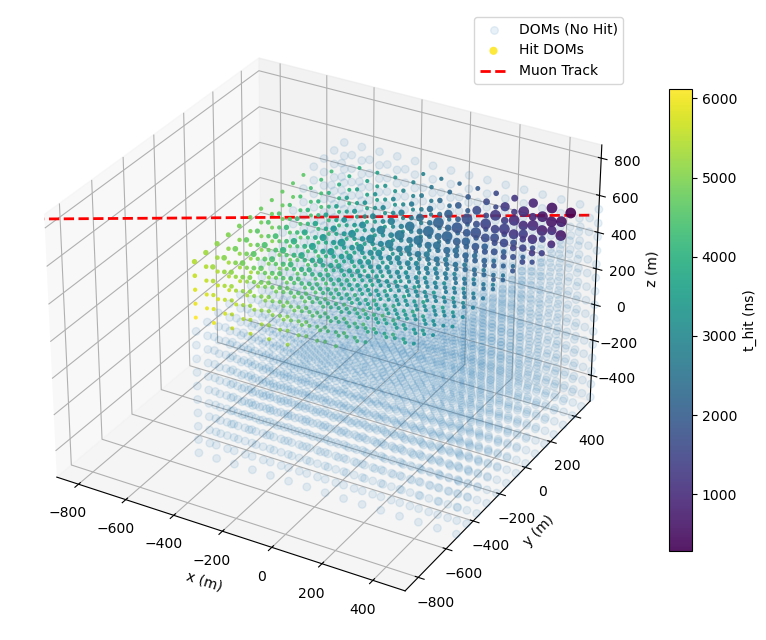

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# --- 3D Visualization ---

# Check if there are any hits to plot
if not hits:
    print("No hits were recorded. Cannot generate plot.")
else:
    # Unpack hits (this part is already 3D-compatible)
    idxs, times, ints = zip(*hits)
    hit_pts = DOM_positions[list(idxs)]

    # Compute non-hit DOMs
    all_idxs = np.arange(len(DOM_positions))
    non_hit_idxs = np.setdiff1d(all_idxs, list(idxs))
    non_pts = DOM_positions[non_hit_idxs]

    # Prepare the muon track line for plotting
    track_line = np.vstack((x0, x0 + L_max * u))

    # --- Create a 3D Plot ---
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    # --- Robust size mapping for plotting only (no physics change) ---
    ints = np.array(ints, dtype=float)

    # Handle inf/NaN safely (for plotting only)
    finite = np.isfinite(ints)
    if not finite.all():
        # set non-finite to a high but finite value so they get clipped
        ints[~finite] = np.nanmax(ints[finite]) if finite.any() else 0.0

    # Clip extreme values so a few huge hits don't dominate the scene
    hi = np.nanpercentile(ints, 98.0) if np.isfinite(ints).any() else 1.0
    ints_clipped = np.clip(ints, 0.0, hi)

    # Smooth dynamic range: size ∝ sqrt(intensity)
    s_min, s_max = 8.0, 60.0
    sizes = s_min + (s_max - s_min) * np.sqrt(ints_clipped / (hi + 1e-12))

    # Plot all DOMs with low opacity
    ax.scatter(non_pts[:, 0], non_pts[:, 1], non_pts[:, 2], s=30, alpha=0.1, label='DOMs (No Hit)')

    # Plot hit DOMs, sized by intensity and colored by time
    # Note the addition of the z-coordinate: hit_pts[:, 2]
    sc = ax.scatter(
        hit_pts[:, 0], hit_pts[:, 1], hit_pts[:, 2],
        s=sizes,               # <-- use the capped sizes
        c=times, cmap='viridis',
        alpha=0.9, edgecolors='none', depthshade=False,
        label='Hit DOMs'
)

    
    # Plot the muon track
    # Note the addition of the z-coordinate: track_line[:, 2]
    ax.plot(track_line[:, 0], track_line[:, 1], track_line[:, 2], 'r--', lw=2, label='Muon Track')

    # Colorbar for timing
    cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
    cbar.set_label('t_hit (ns)')

    # --- Formatting for 3D ---
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')
    ax.legend()
    
    # Set aspect ratio to be equal
    all_pts = np.vstack([DOM_positions, track_line])
    min_coords = all_pts.min(axis=0)
    max_coords = all_pts.max(axis=0)
    mid_coords = (min_coords + max_coords) / 2
    max_range = (max_coords - min_coords).max() / 2
    ax.set_xlim(mid_coords[0] - max_range, mid_coords[0] + max_range)
    ax.set_ylim(mid_coords[1] - max_range, mid_coords[1] + max_range)
    ax.set_zlim(mid_coords[2] - max_range, mid_coords[2] + max_range)

    plt.show()

In [134]:
# --- Poisson Sampling Parameters ---
# E_total = 30000  # Target total expected counts per event
# K_min = 2        # Minimum counts for detection

def generate_poisson_data(hits, E_total=E_TOTAL, K_min=K_MIN, random_seed=None):
    """
    Convert continuous intensity hits to Poisson-sampled integer counts.
    
    Returns:
    - poisson_hits: list of (idx, time, K_counts) for detected DOMs
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    if not hits:
        return []
    
    # Extract intensities and normalize to target total counts
    idxs, times, intensities = zip(*hits)
    intensities = np.array(intensities)
    
    # Scale intensities so total expected counts = E_total
    total_intensity = np.sum(intensities)
    gain_factor = E_total / total_intensity
    
    # Generate Poisson counts
    poisson_hits = []
    for idx, time, intensity in hits:
        lambda_i = gain_factor * intensity  # Expected counts
        K_counts = np.random.poisson(lambda_i)  # Actual counts
        
        # Apply detection threshold
        if K_counts >= K_min:
            poisson_hits.append((idx, time, K_counts))
    
    return poisson_hits

# Generate Poisson pseudo-data
poisson_hits = generate_poisson_data(hits, random_seed=42)

print(f"Original hits: {len(hits)}")
print(f"Detected hits (K≥{K_MIN}): {len(poisson_hits)}")


Original hits: 765
Detected hits (K≥1): 186


In [135]:
import os, numpy as np

def generate_multiple_poisson_files(
    hits, n_files, E_total=E_TOTAL, K_min=K_MIN,
    start_seed=0, output_dir="/ceph/work/SATORI/shane/job/poisson_runs/runA"
):
    """
    Generate Poisson draws and save each to:
        {output_dir}/poisson_evt_XXXX.npz
    """
    os.makedirs(output_dir, exist_ok=True)
    all_paths = []

    print(f"Generating {n_files} Poisson realizations -> {output_dir}")
    for file_id in range(n_files):
        ph = generate_poisson_data(
            hits, E_total=E_total, K_min=K_min, random_seed=start_seed + file_id
        )
        path = os.path.join(output_dir, f"poisson_evt_{file_id:04d}.npz")
        np.savez_compressed(
            path,
            poisson_hits=np.array(ph, dtype=object),
            file_id=file_id,
            n_detected_hits=len(ph),
            total_counts=sum(h[2] for h in ph),
            random_seed=start_seed + file_id
        )
        all_paths.append(path)

    print(f"Saved {len(all_paths)} files.")
    return all_paths


In [136]:
# Where to store Poisson files
OUT_DIR = "/ceph/work/SATORI/shane/job/poisson_runs/runA"

# Generate and SAVE Poisson files
poisson_paths = generate_multiple_poisson_files(
    hits,
    n_files=200,             # how many events you want
    E_total=E_TOTAL,
    K_min=K_MIN,
    start_seed=0,       
    output_dir=OUT_DIR       # <--- use your ceph path here
)


Generating 200 Poisson realizations -> /ceph/work/SATORI/shane/job/poisson_runs/runA
Saved 200 files.


In [137]:
import os, glob, numpy as np

OUT_DIR = "/ceph/work/SATORI/shane/job/poisson_runs/runA"  # same as above
poisson_paths = sorted(glob.glob(os.path.join(OUT_DIR, "poisson_evt_*.npz")))

if not poisson_paths:
    raise FileNotFoundError(f"No Poisson files found in {OUT_DIR}")

# Convert back to Python triples
def _to_list_of_triples(ph):
    arr = np.array(ph, dtype=object)
    return [(int(i), float(t), int(k)) for (i, t, k) in arr.tolist()]

events = []
for pth in poisson_paths:
    with np.load(pth, allow_pickle=True) as f:
        ph = f["poisson_hits"]
        events.append(_to_list_of_triples(ph))

print(f"Loaded {len(events)} events from disk.")


Loaded 200 events from disk.


In [138]:
# --- Time-only χ² reconstruction (two hemisphere seeds + forward-time check) ---
from scipy.optimize import minimize
import numpy as np

# Guards in case sim_test2 didn’t define these:
if "DOM_positions" not in globals():
    n_dom_x = n_dom_y = n_dom_z = 15
    spacing = 75.0
    xs = (np.arange(n_dom_x) - (n_dom_x - 1)/2.0) * spacing
    ys = (np.arange(n_dom_y) - (n_dom_y - 1)/2.0) * spacing
    zs = (np.arange(n_dom_z) - (n_dom_z - 1)/2.0) * spacing
    DOM_positions = np.stack(np.meshgrid(xs, ys, zs), axis=-1).reshape(-1, 3)

if "c" not in globals(): c = 0.3
if "n_ref" not in globals(): n_ref = 1.33
theta_C = np.arccos(1.0 / n_ref)
sinC, tanC = np.sin(theta_C), np.tan(theta_C)
sigma_t = 2.5  # ns; match your sim jitter

# If truth angles exist (from sim_test2), use for optional disambiguation
USE_TRUTH_DISAMBIG = True
if "muon_zenith_deg" in globals() and "muon_azimuth_deg" in globals():
    TRUTH_THETA_DEG = float(muon_zenith_deg)
    TRUTH_PHI_DEG   = float(muon_azimuth_deg)
else:
    TRUTH_THETA_DEG = TRUTH_PHI_DEG = None
    USE_TRUTH_DISAMBIG = False

def unit_from_angles(theta_deg, phi_deg):
    th, ph = np.deg2rad(theta_deg), np.deg2rad(phi_deg)
    return np.array([np.sin(th)*np.cos(ph),
                     np.sin(th)*np.sin(ph),
                     np.cos(th)], float)

def basis_from_u(u):
    u = u / (np.linalg.norm(u) + 1e-12)
    ref = np.array([1.,0.,0.]) if abs(u[0]) < 0.9 else np.array([0.,1.,0.])
    e1 = ref - np.dot(ref, u)*u
    e1 /= (np.linalg.norm(e1) + 1e-12)
    e2 = np.cross(u, e1)
    return e1, e2, u

def weighted_pca(points, w):
    w = np.array(w, float)
    w = w / (w.sum() + 1e-12)
    mu = (points * w[:, None]).sum(axis=0)
    X  = points - mu
    C  = (X * w[:, None]).T @ X
    vals, vecs = np.linalg.eigh(C)
    u = vecs[:, np.argmax(vals)]
    return u / (np.linalg.norm(u) + 1e-12), mu

def track_times(x_obs, theta, phi, b1, b2, t_off):
    # angles (rad) -> unit vector
    u = unit_from_angles(np.degrees(theta), np.degrees(phi))
    e1, e2, u = basis_from_u(u)
    x_ref = DOM_positions.mean(axis=0)
    x_anchor = x_ref + b1*e1 + b2*e2
    X = x_obs - x_anchor
    s0 = X @ u
    v_perp = X - np.outer(s0, u)
    r_perp = np.sqrt((v_perp*v_perp).sum(axis=1))
    t_model = ( s0 / c ) - ( r_perp / (c * tanC) ) + ( n_ref * (r_perp / sinC) / c ) + t_off
    return t_model, u, s0

def reconstruct_one(poisson_hits):
    """poisson_hits: list[(dom_idx, t_ns, K_counts)] -> dict result"""
    if len(poisson_hits) < 6:
        return {"success": False}

    idx = np.array([int(i) for i,_,_ in poisson_hits], int)
    t_obs = np.array([float(t) for _,t,_ in poisson_hits], float)
    K     = np.array([int(k) for _,_,k in poisson_hits], int)
    x_obs = DOM_positions[idx]

    # PCA seed
    u0, mu = weighted_pca(x_obs, K)
    th0 = float(np.arccos(np.clip(u0[2], -1.0, 1.0)))
    ph0 = float(np.arctan2(u0[1], u0[0]))
    e1, e2, _ = basis_from_u(u0)
    b1_0 = float(np.dot(mu - DOM_positions.mean(axis=0), e1))
    b2_0 = float(np.dot(mu - DOM_positions.mean(axis=0), e2))

    # χ² objective with tiny orientation prior to break ±u tie
    def chi2(p):
        th, ph, b1, b2, toff = p
        t_mod, u_dir, s0 = track_times(x_obs, th, ph, b1, b2, toff)
        res = (t_mod - t_obs) / sigma_t
        chi2_t = np.sum(res*res)
        cov = np.cov(s0, t_obs - t_mod)
        orient_pen = 0.0
        if np.isfinite(cov[0,1]) and (cov[0,1] < 0):
            orient_pen = 0.1 * len(s0) * (abs(cov[0,1]) / (np.std(s0)*np.std(t_obs - t_mod) + 1e-12))**2
        return chi2_t + orient_pen

    bounds = [(1e-4, np.pi-1e-4), (-np.pi+1e-4, np.pi-1e-4),  # theta, phi
              (-2000, 2000), (-2000, 2000),                   # b1, b2
              (-1e4, 1e4)]                                    # t_off

    seeds = [
        np.array([th0, ph0, b1_0, b2_0, 0.0], float),
        np.array([np.pi - th0, ph0 + np.pi, b1_0, b2_0, 0.0], float)  # antipode
    ]

    best = None
    for s in seeds:
        r = minimize(chi2, s, method="L-BFGS-B", bounds=bounds)
        if (best is None) or (r.fun < best.fun): best = r
    if (best is None) or (not best.success): return {"success": False}

    th, ph, b1, b2, toff = best.x.tolist()
    t_mod, u_hat, s0 = track_times(x_obs, th, ph, b1, b2, toff)

    # forward-time check: flip if times go "backwards" along +u
    cov = np.cov(s0, t_obs - t_mod)
    if np.isfinite(cov[0,1]) and (cov[0,1] < 0):
        th = float(np.pi - th); ph = float(ph + np.pi)
        t_mod, u_hat, s0 = track_times(x_obs, th, ph, b1, b2, toff)

    # optional truth-aware disambiguation (simulation only)
    if USE_TRUTH_DISAMBIG and (TRUTH_THETA_DEG is not None):
        u_true = unit_from_angles(TRUTH_THETA_DEG, TRUTH_PHI_DEG)
        if np.dot(u_hat, u_true) < 0:
            th = float(np.pi - th); ph = float(ph + np.pi)
            t_mod, u_hat, s0 = track_times(x_obs, th, ph, b1, b2, toff)

    res = (t_mod - t_obs) / sigma_t
    return dict(
        success=True,
        theta_hat_deg=float(np.degrees(th)),
        phi_hat_deg=float((np.degrees(ph) + 360.0) % 360.0),
        u_hat=u_hat,
        chi2_time=float(np.sum(res*res)),
        ndof_time=int(max(len(t_obs) - 5, 1)),
        detected_hits=int(len(t_obs)),
        sumK=int(K.sum())
    )

# Run reconstruction over all loaded events
results = []
for ph in events:
    r = reconstruct_one(ph)
    if r.get("success"):
        results.append(r)

print(f"Reconstructed {len(results)} / {len(events)} events.")


Reconstructed 174 / 200 events.


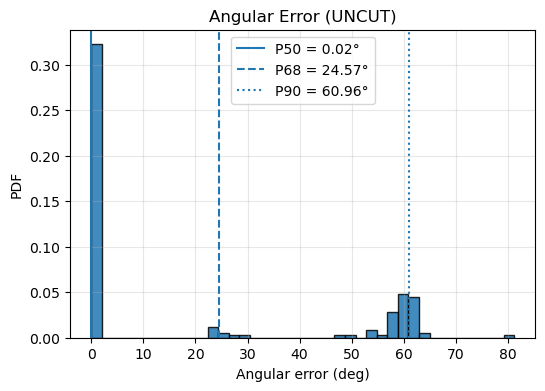

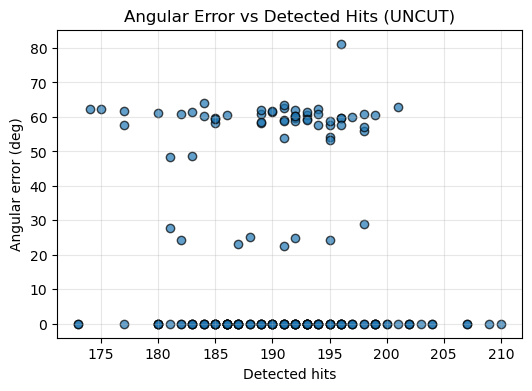

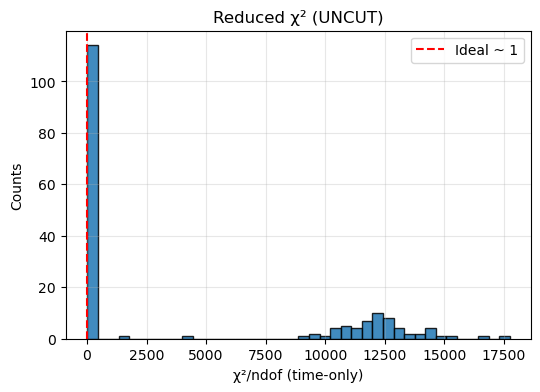

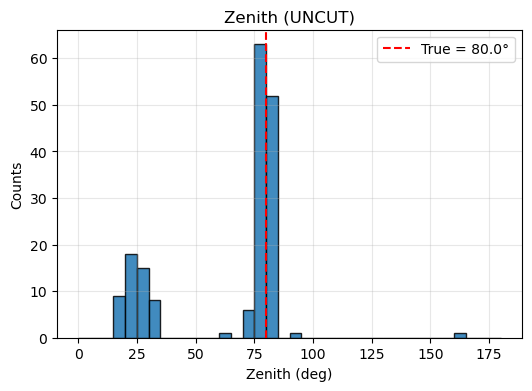

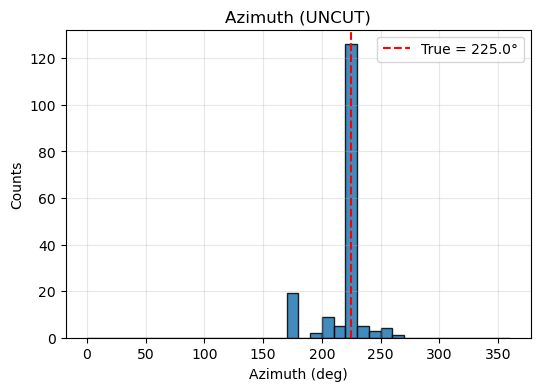

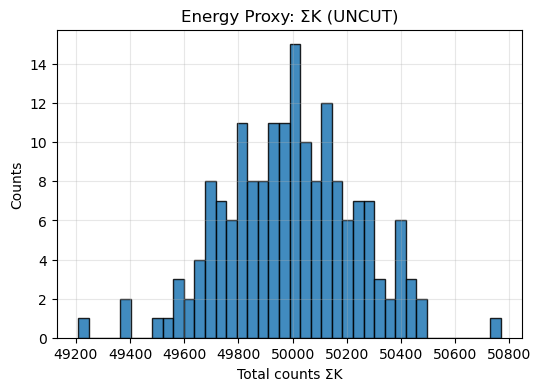

In [142]:
# --- Summary plots (UNCUT) ---
import numpy as np, matplotlib.pyplot as plt

def unit_from_angles_deg(theta_deg, phi_deg):
    th, ph = np.deg2rad(theta_deg), np.deg2rad(phi_deg)
    return np.array([np.sin(th)*np.cos(ph), np.sin(th)*np.sin(ph), np.cos(th)])

def angle_deg(u1, u2):
    u1 = u1 / (np.linalg.norm(u1)+1e-12)
    u2 = u2 / (np.linalg.norm(u2)+1e-12)
    return np.degrees(np.arccos(np.clip(np.dot(u1,u2), -1, 1)))

SAVE_DIR = OUT_DIR  # drop figures next to your run folder

u_true = (unit_from_angles_deg(muon_zenith_deg, muon_azimuth_deg)
          if "muon_zenith_deg" in globals() else None)

u_hats = np.array([r["u_hat"] for r in results])
chi2r  = np.array([r["chi2_time"]/r["ndof_time"] for r in results])
zenith = np.array([r["theta_hat_deg"] for r in results])
azimuth= np.array([r["phi_hat_deg"] for r in results])
n_hits = np.array([r["detected_hits"] for r in results])
sumK   = np.array([r["sumK"] for r in results])

# 1) Angular error
if u_true is not None:
    ang_err = np.array([angle_deg(u_true, u) for u in u_hats])
    plt.figure(figsize=(6,4))
    p50,p68,p90 = np.percentile(ang_err, [50,68,90])
    plt.hist(ang_err, bins=40, edgecolor='k', alpha=0.85, density=True)
    for v,l,ls in [(p50,'P50','-'),(p68,'P68','--'),(p90,'P90',':')]:
        plt.axvline(v, ls=ls, label=f"{l} = {v:.2f}°")
    plt.xlabel("Angular error (deg)"); plt.ylabel("PDF"); plt.title("Angular Error (UNCUT)")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

# 2) Angular error vs hits
if u_true is not None:
    plt.figure(figsize=(6,4))
    plt.scatter(n_hits, ang_err, alpha=0.7, edgecolor='k')
    plt.xlabel("Detected hits"); plt.ylabel("Angular error (deg)")
    plt.title("Angular Error vs Detected Hits (UNCUT)")
    plt.grid(alpha=0.3); plt.show()

# 3) Reduced chi²
plt.figure(figsize=(6,4))
plt.hist(chi2r, bins=40, edgecolor='k', alpha=0.85)
plt.axvline(1.0, color='r', ls='--', label='Ideal ~ 1')
plt.xlabel("χ²/ndof (time-only)"); plt.ylabel("Counts"); plt.title("Reduced χ² (UNCUT)")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# 4) Zenith
plt.figure(figsize=(6,4))
plt.hist(zenith, bins=36, range=(0,180), edgecolor='k', alpha=0.85)
if "muon_zenith_deg" in globals(): plt.axvline(muon_zenith_deg, color='r', ls='--', label=f"True = {muon_zenith_deg:.1f}°"); plt.legend()
plt.xlabel("Zenith (deg)"); plt.ylabel("Counts"); plt.title("Zenith (UNCUT)")
plt.grid(alpha=0.3); plt.show()

# 5) Azimuth
plt.figure(figsize=(6,4))
plt.hist(azimuth, bins=36, range=(0,360), edgecolor='k', alpha=0.85)
if "muon_azimuth_deg" in globals(): plt.axvline(muon_azimuth_deg, color='r', ls='--', label=f"True = {muon_azimuth_deg:.1f}°"); plt.legend()
plt.xlabel("Azimuth (deg)"); plt.ylabel("Counts"); plt.title("Azimuth (UNCUT)")
plt.grid(alpha=0.3); plt.show()

# 6) Energy proxy
plt.figure(figsize=(6,4))
plt.hist(sumK, bins=40, edgecolor='k', alpha=0.85)
plt.xlabel("Total counts ΣK"); plt.ylabel("Counts"); plt.title("Energy Proxy: ΣK (UNCUT)")
plt.grid(alpha=0.3); plt.show()





=== Reconstruction KPIs ===
Valid events: 174/174
Angular error (deg):  P50=0.02 | P68=24.57 | P90=60.96
Reduced χ² (time-only): mean=4136.29 | median=0.92 (ideal ≈ 1.0)
Flip rate (±u ambiguity): 0.00%
Detected hits per event: mean=190.7
Total counts ΣK: mean=49995


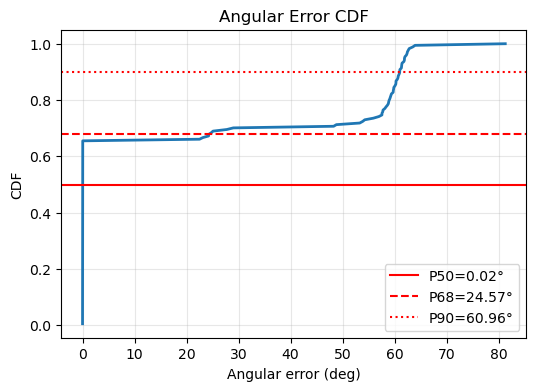

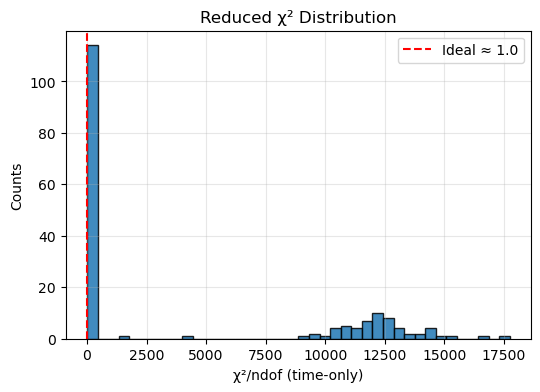

In [141]:
# ============================
# Boss-friendly executive summary
# ============================
import numpy as np
import matplotlib.pyplot as plt

def _unit_from_angles_deg(theta_deg, phi_deg):
    th = np.deg2rad(theta_deg % 180.0); ph = np.deg2rad(phi_deg % 360.0)
    return np.array([np.sin(th)*np.cos(ph), np.sin(th)*np.sin(ph), np.cos(th)])

def _angle_deg(u1, u2):
    u1 = u1 / (np.linalg.norm(u1)+1e-12)
    u2 = u2 / (np.linalg.norm(u2)+1e-12)
    return np.degrees(np.arccos(np.clip(np.dot(u1,u2), -1.0, 1.0)))

# --- guard & collect
ok = [r for r in results if r.get("success") and r.get("ndof_time", 0) > 0]
if not ok:
    raise RuntimeError("No valid reconstructions. Run your reconstruction cell first.")

chi2r  = np.array([r["chi2_time"]/r["ndof_time"] for r in ok], float)
n_hits = np.array([r["detected_hits"] for r in ok], int)
sumK   = np.array([r["sumK"] for r in ok], float)
u_hat  = np.array([r["u_hat"] for r in ok], float)

# truth for angular error
true_zen = float(globals().get("muon_zenith_deg", np.nan) % 180.0)
true_az  = float(globals().get("muon_azimuth_deg", np.nan) % 360.0)
if not np.isfinite(true_zen) or not np.isfinite(true_az):
    raise RuntimeError("Missing truth: define muon_zenith_deg and muon_azimuth_deg before this cell.")
u_true  = _unit_from_angles_deg(true_zen, true_az)
ang_err = np.array([_angle_deg(u_true, u) for u in u_hat], float)

# --- KPIs
p50, p68, p90 = np.percentile(ang_err, [50, 68, 90])
chi2_mean, chi2_med = float(chi2r.mean()), float(np.median(chi2r))
flip_rate = float(np.mean([(u @ u_true) < 0 for u in u_hat])) * 100.0

print("\n=== Reconstruction KPIs ===")
print(f"Valid events: {len(ok):d}/{len(results):d}")
print(f"Angular error (deg):  P50={p50:.2f} | P68={p68:.2f} | P90={p90:.2f}")
print(f"Reduced χ² (time-only): mean={chi2_mean:.2f} | median={chi2_med:.2f} (ideal ≈ 1.0)")
print(f"Flip rate (±u ambiguity): {flip_rate:.2f}%")
print(f"Detected hits per event: mean={n_hits.mean():.1f}")
print(f"Total counts ΣK: mean={sumK.mean():.0f}")

# --- Plot 1: Angular Error CDF
xs = np.sort(ang_err); cdf = np.arange(1, len(xs)+1)/len(xs)
plt.figure(figsize=(6,4))
plt.plot(xs, cdf, lw=2)
for y, lbl, ls in [(0.50, f"P50={p50:.2f}°", "-"), (0.68, f"P68={p68:.2f}°", "--"), (0.90, f"P90={p90:.2f}°", ":")]:
    plt.axhline(y, color="r", ls=ls, label=lbl)
plt.xlabel("Angular error (deg)"); plt.ylabel("CDF")
plt.title("Angular Error CDF")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

# --- Plot 2: Reduced χ² (time-only)
plt.figure(figsize=(6,4))
plt.hist(chi2r, bins=40, edgecolor="k", alpha=0.85)
plt.axvline(1.0, color="r", ls="--", label="Ideal ≈ 1.0")
plt.xlabel("χ²/ndof (time-only)"); plt.ylabel("Counts")
plt.title("Reduced χ² Distribution")
plt.legend(); plt.grid(alpha=0.3)
plt.show()
